In [1]:
#!pip install openpyxl
#!pip install pandasql
from pandasql import sqldf 
from sqlite3 import connect
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge

import pandas as pd
import numpy as np
import requests
import scipy.stats as stats
mysql = lambda q: sqldf(q, globals())

In [2]:
# Loading the data into the appropriate variables

team     = pd.read_excel('Interview Project Data.xlsx', sheet_name='Team Data')

In [3]:
seating  = pd.read_excel('Interview Project Data.xlsx', sheet_name='Seating Chart')

In [4]:
packages = pd.read_excel('Interview Project Data.xlsx', sheet_name='Customer Package Type')

In [5]:
sales    = pd.read_excel('Interview Project Data.xlsx', sheet_name='Ticket Sales Data')

In [6]:
scans    = pd.read_excel('Interview Project Data.xlsx', sheet_name='Ticket Scan Data')

In [7]:
# Converting entries in scan_datetime from UTC to PST

scans['scan_datetime'] = scans['scan_datetime'].dt.tz_localize('US/Central').dt.tz_convert('US/Pacific')
scan_datetime = scans['scan_datetime']

**1. Do evening games (6:00pm or later) on average, have a higher attendance than afternoon games (Before 6:00pm)? Also, provide average attendance per game by month.**

In [8]:
# Total Evening Games Attendence / Total Evening Games
# First block finds the total occurrences of ticket scans where the hour ('H') is greater than or equal to 18, which 
# represents 6 PM on a 24-hour clock (evening game)
# Second block finds the total number of evening games

print(mysql(" \
        SELECT COUNT(*) AS 'Total Evening Games Attendence' \
        FROM scans \
        WHERE (CAST(strftime('%H', event_datetime) AS int) >= 18)"))

print(mysql(" \
        SELECT COUNT(DISTINCT(event_datetime)) AS 'Total Evening Games' \
        FROM scans \
        WHERE (CAST(strftime('%H', event_datetime) AS int) >= 18)"))



# Total Afternoon Games Attendence / Total Afternoon Games
# First block finds the total occurrences of ticket scans where the hour ('H') is less than 18, which represents 6 PM 
# on a 24-hour clock (afternoon game)
# Second block finds the total number of afternoon games

print(mysql(" \
        SELECT COUNT(*) AS 'Total Afternoon Games Attendence' \
        FROM scans \
        WHERE (CAST(strftime('%H', event_datetime) AS int) < 18)"))

print(mysql(" \
        SELECT COUNT(DISTINCT(event_datetime)) AS 'Total Afternoon Games' \
        FROM scans \
        WHERE (CAST(strftime('%H', event_datetime) AS int) < 18)"))



# Total Attendence by Month / Total Games by Month
# First block finds the total occurrences of ticket scans, grouped by month
# Second block finds the total number of games, in order to compute average scans/game

print(mysql(" \
        SELECT DISTINCT(strftime('%m', event_datetime)) AS Month, \
        COUNT(*) AS 'Total Attendence by Month' \
        FROM scans \
        GROUP BY strftime('%m', event_datetime)"))

print(mysql(" \
        SELECT DISTINCT(strftime('%m', event_datetime)) AS Month, \
        COUNT(DISTINCT(event_datetime)) AS 'Total Games by Month' \
        FROM scans \
        GROUP BY strftime('%m', event_datetime)"))

   Total Evening Games Attendence
0                          201414
   Total Evening Games
0                   34
   Total Afternoon Games Attendence
0                             35056
   Total Afternoon Games
0                      7
  Month  Total Attendence by Month
0    01                      22071
1    02                      26476
2    03                      39331
3    04                      24709
4    10                      17102
5    11                      67867
6    12                      38914
  Month  Total Games by Month
0    01                     5
1    02                     4
2    03                     6
3    04                     4
4    10                     3
5    11                    12
6    12                     7


**2. For all games, provide the average number of fans in arena 2hrs prior to start time, 1hr prior to start time, and at start time.
a. PLEASE NOTE: scan date and time is in Central Time Zone; event date and time is in Pacific Time Zone.**

In [9]:
# Since the min scan time is 10:12:55 AM and the max scan time is 22:15:16 = 10:15:16 PM, there are no issues with 
# time arithmetic in this manner; time arithmetic defined as finding the difference in datetimes by converting time to
# a 6-digit number on the 24-hour clock, where a difference of 20000 indicates a 2 hour difference (i.e., 12:00:00 -
# 10:00:00 = 120000 - 100000 = 20000 = 02:00:00 = 2 hours). All scans occur on the same date of the event; if someone
# scanned in at 1 AM the following day, however, for a 7 PM game (although unlikely), this time arithmetic would NOT 
# work. However, since the maximum scan datetime is 10:15:16 PM, this is not an issue.

# 2 Hours prior to start time (difference >= 20000)
print(mysql(" \
        SELECT CAST(COUNT(*)/41 AS double) AS 'Avg # of Fans at 2 Hours' \
        FROM scans \
        WHERE \
        (CAST(strftime('%H%M%S', event_datetime) AS int) - CAST(strftime('%H%M%S', scan_datetime) AS int) >= 20000)"))

# 1 Hour prior to start time (difference >= 10000)
print(mysql(" \
        SELECT CAST(COUNT(*)/41 AS double) AS 'Avg # of Fans at 1 Hour' \
        FROM scans \
        WHERE \
        (CAST(strftime('%H%M%S', event_datetime) AS int) - CAST(strftime('%H%M%S', scan_datetime) AS int) >= 10000)"))

# At start time (difference >= 0)
print(mysql(" \
        SELECT CAST(COUNT(*)/41 AS double) AS 'Avg # of Fans at Start' \
        FROM scans \
        WHERE \
        (CAST(strftime('%H%M%S', event_datetime) AS int) - CAST(strftime('%H%M%S', scan_datetime) AS int) >= 0)"))

   Avg # of Fans at 2 Hours
0                       2.0
   Avg # of Fans at 1 Hour
0                    706.0
   Avg # of Fans at Start
0                  3574.0


**3. Count the number of accounts with both tickets bought >= 5 and scans >= 3. Of these, how many are members?**

In [10]:
# The bottom two chunks of code are very large in size, as there are a lot of inner joins going on to see the
# intersections of conditions. Below are some subqueries used as methods to view the filtered data, some of which were
# incorporated into the final code. They have been commented out, as they are not necessary to run in order to acquire 
# the final result.

# SQ 1: All data necessary from [packages], [scans], [sales] sheets, joined on seat_unique_id and customer_unique_id
# Used to see how data will look all together in one dataframe
#
# mysql(" \
#         SELECT * \
#         FROM sales \
#         LEFT JOIN scans ON sales.seat_unique_id = scans.seat_unique_id \
#         LEFT JOIN packages ON sales.customer_unique_id = packages.customer_unique_id")


# SQ 2: Finds customer_unique_id and count of events attended from [scans] sheet, all grouped by customer, since [scans] 
# does not include customer_unique_id
#
# mysql(" \
#         SELECT customer_unique_id, COUNT(event_datetime) \
#         FROM ( \
#             SELECT * \
#             FROM sales \
#             LEFT JOIN scans ON sales.seat_unique_id = scans.seat_unique_id \
#             WHERE (scans.event_datetime != 'None')) \
#         GROUP BY (customer_unique_id)")

# SQ 3: Counting number of tickets purchased, grouped by customer, then finding which customers purchased five or more
# tickets
#
# mysql(" \
#         SELECT customer_unique_id AS top_buyers \
#         FROM ( \
#             SELECT customer_unique_id, COUNT(customer_unique_id) AS count_purchased \
#             FROM sales \
#             GROUP BY (customer_unique_id)) \
#         WHERE (count_purchased >= 5)")

# SQ 4: Counting number of tickets scanned, grouped by customer, then finding which customers scanned in three or more times
# mysql(" \
#         SELECT customer_unique_id AS top_attendees \
#         FROM ( \
#             SELECT customer_unique_id, COUNT(customer_unique_id) AS count_attended \
#             FROM sales \
#             LEFT JOIN scans ON sales.seat_unique_id = scans.seat_unique_id \
#             WHERE (scans.event_datetime != 'None') \
#             GROUP BY (customer_unique_id)) \
#         WHERE (count_attended >= 3) ")

# SQ 5: Counts number of customers who scanned in that are members
# mysql(" \
#         SELECT COUNT(customer_unique_id) \
#         FROM ( \
#             SELECT * \
#             FROM sales \
#             LEFT JOIN scans ON sales.seat_unique_id = scans.seat_unique_id \
#             LEFT JOIN packages ON sales.customer_unique_id = packages.customer_unique_id \
#             WHERE (sales.event_datetime != 'None'))")

# Question 3A: Count of Inner join of SQ 3 and SQ 4, indicating fans whose purchased tickets >= 5, scans >= 3
print(mysql(" \
        SELECT COUNT(*) AS top_fans \
        FROM ( \
            SELECT customer_unique_id AS top_buyers \
            FROM ( \
                SELECT customer_unique_id, COUNT(customer_unique_id) AS count_purchased \
                FROM sales \
                GROUP BY (customer_unique_id)) \
            WHERE (count_purchased >= 5)) \
        INNER JOIN ( \
            SELECT customer_unique_id AS top_attendees \
            FROM ( \
                SELECT customer_unique_id, COUNT(customer_unique_id) AS count_attended \
                FROM sales \
                LEFT JOIN scans ON sales.seat_unique_id = scans.seat_unique_id \
                WHERE (scans.event_datetime != 'None') GROUP BY (customer_unique_id)) \
            WHERE (count_attended >= 3)) \
        ON top_buyers = top_attendees"))

# Question 3B: Count of Inner Join of (Inner Join of SQ 3 and SQ 4) and packages, indicating members whose purchased 
# tickets >= 5, scans >= 3
print(mysql(" \
        SELECT COUNT(*) AS top_members \
        FROM ( \
            SELECT top_attendees AS top_fans \
            FROM ( \
                SELECT customer_unique_id AS top_buyers \
                FROM (\
                    SELECT customer_unique_id, COUNT(customer_unique_id) AS count_purchased \
                    FROM sales \
                    GROUP BY (customer_unique_id)) \
                    WHERE (count_purchased >= 5)) \
                INNER JOIN ( \
                    SELECT customer_unique_id AS top_attendees \
                    FROM ( \
                        SELECT customer_unique_id, COUNT(customer_unique_id) AS count_attended \
                        FROM sales \
                        LEFT JOIN scans ON sales.seat_unique_id = scans.seat_unique_id \
                        WHERE (scans.event_datetime != 'None') \
                        GROUP BY (customer_unique_id)) \
                    WHERE (count_attended >= 3)) \
                ON top_buyers = top_attendees) \
            INNER JOIN packages ON top_fans = packages.customer_unique_id"))

   top_fans
0      3883
   top_members
0         2411


**4. Identify and rank the top 10 sections that are, on average, the most filled to their capacity.**

In [11]:
# List of sections from [seating] sheet
sections = np.unique(seating['section_name']).tolist()
section_capacity = []

# Capacity of each section, saved into a list
current_row = 0
for section in sections:
    seats = 0
    for row in range(current_row, len(seating)):
        if seating['section_name'][row] == section:
            seats += seating['seat_count'][row]
            current_row += 1
        else:
            break
    section_capacity.append(seats)

# Total scans for each section for entire season
total_section_scans = [0] * (len(sections))
for scan in range(len(scans)):
    section = scans['section_name'][scan]
    total_section_scans[sections.index(section)] += 1

# Average seating for each section per game (41 home games)
average_seating = []
for total in total_section_scans:
    average_seating.append(total/41)
    
# Percent filled = Average seating / Total capacity (By section)
percent_filled = []
for i in range(len(section_capacity)):
    percent_filled.append(average_seating[i]/section_capacity[i])

# Dictionary where key = section number, value = percent_filled
section_percents = {}
for x in range(len(sections)):
    section_percents[sections[x]] = percent_filled[x]

# Ranking the section_percents dictionary in descending order
ranked = dict(sorted(section_percents.items(), key = lambda item: item[1], reverse = True))
ranked_keys = []
for key in ranked:
    ranked_keys.append(key)
    
# Top 10 Sections filled
for rank in range(10):
    print(rank + 1, '. Section', ranked_keys[rank], ';', section_percents[ranked_keys[rank]]*100, '% capacity on average.')

1 . Section 106 ; 74.53600233213487 % capacity on average.
2 . Section 102 ; 74.4305840004965 % capacity on average.
3 . Section 105 ; 73.69886690992894 % capacity on average.
4 . Section 114 ; 73.08943089430895 % capacity on average.
5 . Section 107 ; 73.03666271335018 % capacity on average.
6 . Section 113 ; 72.72107916609892 % capacity on average.
7 . Section 115 ; 72.46147566078172 % capacity on average.
8 . Section 109 ; 71.57275021026072 % capacity on average.
9 . Section 101 ; 70.44254463163189 % capacity on average.
10 . Section 117 ; 69.82355993772704 % capacity on average.


**5. Is there a correlation between the opponent team having a higher Vegas over/under win total
(coming into the 21/22 season) and higher attendance in the 21/22 season?**

In [12]:
# Creating the list of opposing teams. Special case for Portland, since this is the only team whose name is two words
# (Trail Blazers)
opponents = []
for x in team['Team Full Name']:
    if 'Portland' in x:
        string = x.rsplit(' ', 2)[0]
    else:
        string = x.rsplit(' ', 1)[0]
    if string not in opponents:
        opponents.append(string)
        
# Vegas Over/Under 21/22 for each team
vegas     = team['Vegas Over/Under 21/22']
all_teams = team['Team Full Name'].tolist()
del vegas[all_teams.index('Los Angeles Clippers')]

# List of opponent for each game, corresponding to event_datetime in [sales] sheet
game_opponent = []
for row in range(len(sales)):
    string = sales['event_name'][row]
    new_string = string.split(' - ')
    result = ''.join([i for i in new_string[1] if not i.isdigit()])
    if 'New Orleans' in string:
        result = 'New Orleans'
    else:
        result = result.replace(' //', '')
    game_opponent.append(result)
sales['game_opponent'] = game_opponent

# Left-joining the [scans] sheet and [sales] sheet on seat_unique_id
join = scans.merge(sales, on = 'seat_unique_id', how = 'left')

# Empty opponents_attendance list
opponents_attendance = [0] * (len(opponents))

# For each row in [join] (same as row in [scans]), total attendance of each event with respect to the opposing team is
# updated by +1 in opponent_attendance
for x in range(len(join)):
    team = join['game_opponent'][x]
    opponents_attendance[opponents.index(team)] += 1
    
vegas_df = pd.read_csv('Vegas_Attendance.csv')
vegas_df['Vegas'] = vegas
vegas_df['Attendance'] = opponents_attendance
vegas_df.to_csv('Vegas_Attendance.csv')

                        Vegas Over/Under 21/22  Opponents Attendance
Vegas Over/Under 21/22                1.000000              0.203285
Opponents Attendance                  0.203285              1.000000


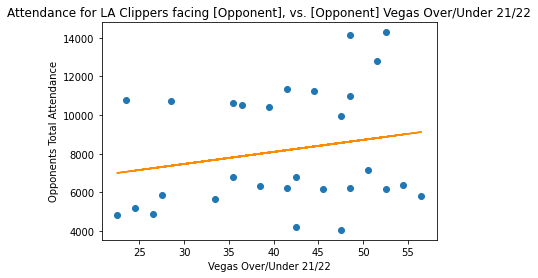

In [13]:
# Creating data frame for vegas data and opponents_attendance data
df = pd.DataFrame({'Vegas Over/Under 21/22':vegas})
df['Opponents Attendance'] = opponents_attendance

# Finding Pearson's Correlation Coefficient
print(df.corr())

# Graphing the data to visualize the relationship between opponents attendance and Vegas Over/Under 21/22
m, b = np.polyfit(vegas, opponents_attendance, 1)

plt.scatter(vegas, opponents_attendance)
plt.plot(vegas, m*vegas + b, color='darkorange')
plt.xlabel('Vegas Over/Under 21/22') 
plt.ylabel('Opponents Total Attendance')
plt.title('Attendance facing [Opponent], vs. [Opponent] Vegas Over/Under 21/22')
plt.show()

**6. Pull data from Basketball Reference around [21/22 game results](https://www.basketball-reference.com/teams/LAC/2022_games.html). Is there a difference in quantity
of tickets purchased and attendance between home games within the following seven days from the third game of a win streak (W3), vs other games? Optional: Include code for scraping Basketball Reference and pulling in data.
a. Hint: LAC had four win streaks of at least three games last season. You will be analyzing the sales/scans of the 8 games that occurred after one of these win streaks, compared to the remaining 33 games.**

In [14]:
# Data Scraping

URL = "https://www.basketball-reference.com/teams/LAC/2022_games.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

# Game Outcome
results = soup.find_all(attrs = {"data-stat": "game_result"})
outcomes = []
for row in results:
    if row.text == 'L' or row.text == 'W':
        outcomes.append(row.text)

# Game Dates
events = soup.find_all(attrs = {"data-stat": "date_game"})
dates = []
for row in events:
    if row.text != 'Date':
        date = row.text
        datetime_object = datetime.strptime(date, '%a, %b %d, %Y')
        datetime_object = datetime_object.strftime('%m/%d/%y')
        dates.append(datetime_object)

# Game Streaks
stints = soup.find_all(attrs = {"data-stat": "game_streak"})
streaks = []
for row in stints:
    if row.text != 'Streak':
        streaks.append((row.text).split(' ')[1])


        

In [15]:
# Formatting dates scans['event_datetime'] to %m/%d/%y
home_dates_raw = np.unique(scans['event_datetime']).tolist()
home_dates = []
for date in home_dates_raw:
    x = int(str(date)[0:10])
    y = datetime.fromtimestamp(x) 
    home_dates.append(y.strftime('%m/%d/%y'))
    
# Determining sales and scans for each home game, respectively, from [scans] sheet and [sales] sheet
home_sales = [0] * len(home_dates)
home_scans = [0] * len(home_dates)


for x in range(len(sales)):
    date = (sales['event_datetime'][x]).strftime('%m/%d/%y')
    home_sales[home_dates.index(date)] += 1
    
for x in range(len(scans)):
    date = (scans['event_datetime'][x]).strftime('%m/%d/%y')
    home_scans[home_dates.index(date)] += 1
        
# Converting dates of games to which day in the season the game was played, starting with the date of the first home
# game (10/23/21 = 1), for date arithmetic
day_of_season = []
day_of_season_home = []
for i in range(len(dates)):
    str_d1 = dates[0]
    str_d2 = dates[i]
    
    d1 = datetime.strptime(str_d1, "%m/%d/%y")
    d2 = datetime.strptime(str_d2, "%m/%d/%y")
    
    delta = d2 - d1
    
    day_of_season.append(delta.days)
    
    if dates[i] in home_dates:
        day_of_season_home.append(delta.days)
    
# Identifying which days of the season where a third consecutive win occurred, both home games and away games
third_win_game = []
for streak in range(len(streaks)):
    if int(streaks[streak]) == 3 and outcomes[streak] == 'W':
        third_win_game.append(day_of_season[streak])

# Each total sales in [home_sales] and total scans in [home_scans] that occurred within seven days of each 
# day_of_season in third_win_game is add to the appropriate list 
following_sales = []
following_scans = []

for num in range(0, len(third_win_game)):
    for i in range(third_win_game[num] + 1, third_win_game[num] + 8):
        if i in day_of_season_home:
            following_sales.append(home_sales[day_of_season_home.index(i)])
            following_scans.append(home_scans[day_of_season_home.index(i)])

# All other sales and scans (all sales and scans excluding following_sales and following_scans, respectively)
normal_sales = home_sales
normal_scans = home_scans

for sale in following_sales:
    del normal_sales[normal_sales.index(sale)]
for scan in following_scans:
    del normal_scans[normal_scans.index(scan)]

In [16]:
# Two Sample T-Test

n_sales = np.array(normal_sales)
n_scans = np.array(normal_scans)

f_sales = np.array(following_sales)
f_scans = np.array(following_scans)

# Difference between sales in seven days following third consecutive win vs. all other sales?
print(stats.ttest_ind(a = n_sales, b = f_sales, equal_var = True))
# Difference between scans in seven days following third consecutive win vs. all other scans?
print(stats.ttest_ind(a = n_scans, b = f_scans, equal_var = True))

Ttest_indResult(statistic=-1.2740534660239133, pvalue=0.21018463529035372)
Ttest_indResult(statistic=-1.5988502180762474, pvalue=0.11792523713217326)


**Are Big Spenders Big Attendees?**

In [17]:
customers = np.unique(sales['customer_unique_id']).tolist()

customer_tickets = [0] * len(customers)
customer_sales = [0] * len(customers)

for row in range(len(sales)):
    customer = sales['customer_unique_id'][row]
    customer_tickets[customers.index(customer)] += 1
    customer_sales[customers.index(customer)] += int(sales['price'][row])

In [18]:
join = scans.merge(sales, on = 'seat_unique_id', how = 'left')
customer_scans = [0] * len(customers)
for row in range(len(join)):
    customer = join['customer_unique_id'][row]
    customer_scans[customers.index(customer)] += 1

In [19]:
customer_attendance = []
for i in range(len(customers)):
    attendance = customer_scans[i] / customer_tickets[i]
    customer_attendance.append(attendance)

In [20]:
cust_df = pd.read_csv('Customer_Data.csv')

cust_df['customer_unique_id'] = customers
cust_df['customer_total_sales'] = customer_sales
cust_df['customer_attendance'] = customer_attendance
cust_df['customer_tickets'] = customer_tickets
cust_df['customer_scans'] = customer_scans

cust_df_ = cust_df.merge(packages, on = 'customer_unique_id', how = 'left')
member_bin = []

for package in cust_df_['price_code_type']:
    if package == 'Half Season' or package == 'Full Season':
        member_bin.append(1)
    else:
        member_bin.append(0)

cust_df['is_member'] = member_bin
cust_df.to_csv('Customer_Data.csv')

**Attendance Prediction Model**

In [21]:
# Data Scraping
# URL = "https://www.basketball-reference.com/leagues/NBA_2022_ratings.html"
# page = requests.get(URL)
# soup = BeautifulSoup(page.content, "html.parser")

# teams = []

# results = soup.find_all(attrs = {"data-stat": "team_name"})
# for row in results:
#     if row.text != 'Team':
#         if row.text == 'Portland Trail Blazers':
#             teams.append((row.text).rsplit(' ', 2)[0])
#         else:
#             teams.append((row.text).rsplit(' ', 1)[0])

# rtg = []
# results = soup.find_all(attrs = {"data-stat": "net_rtg_adj"})
# for row in results:
#     if row.text != 'NRtg/A':
#         rtg.append(float(row.text))

# team_rtg = {}
# for x in range(len(teams)):
#     team_rtg[teams[x]] = rtg[x]

In [22]:
# Percent Stadium Capacity
arena_capacity = sum(seating['seat_count'])

games_raw = np.unique(sales['event_datetime']).tolist()
games = []
for date in games_raw:
    x = int(str(date)[0:10])
    y = datetime.fromtimestamp(x) 
    games.append(y)

num_scans = [0] * len(games)
for row in range(len(scans)):
    event_datetime = scans['event_datetime'][row]
    num_scans[games.index(event_datetime)] += 1

event_capacity = []
for num in num_scans:
    event_capacity.append(num/arena_capacity)

In [23]:
URL = "https://wegrynenterprises.com/2022/07/14/ranking-the-most-loved-nba-teams/"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

info = []
teams = []
following = []

results = soup.find_all("td")
for row in results:
    info.append(row.text)
info = info[4:len(info)]

for x in range(len(info)):
    if x % 4 == 1:
        if info[x] != 'LA Clippers':
            if info[x] == 'Portland Trail Blazers':
                teams.append(info[x].rsplit(' ', 2)[0])
            elif info[x] == 'LA Lakers':
                teams.append('Los Angeles')
            else:
                teams.append(info[x].rsplit(' ', 1)[0])
    elif x % 4 == 3:
        following.append(info[x])

games_following = []
for team in range(len(opponents)):
    follows = (following[teams.index(opponents[team])]).replace(',', '')
    games_following.append(int(follows))

In [24]:
# # Opponent Net Adjusted Rating
# opponent_rtg = []
# opponents = []
# event_names = [''] * len(games)
# for event in range(len(scans)):
#     event_datetime = scans['event_datetime'][event]
#     if scans['event_name'][event] not in event_names:
#         event_names[games.index(event_datetime)] = scans['event_name'][event]

# for string in event_names:
#     new_string = string.split(' - ')
#     result = ''.join([i for i in new_string[1] if not i.isdigit()])
#     if 'New Orleans' in string:
#         result = 'New Orleans'
#     else:
#         result = result.replace(' //', '')
#     opponents.append(result)

# for opponent in opponents:
#     opponent_rtg.append(team_rtg[opponent])

In [25]:
# Average Ticket Price
total_sales = [0] * len(games)
total_profit = [0] * len(games)
avg_price = []

for ticket in range(len(sales)):
    event_datetime = sales['event_datetime'][ticket]
    total_profit[games.index(event_datetime)] += sales['price'][ticket]
    total_sales[games.index(event_datetime)] += 1

for num in range(len(total_profit)):
    avg_price.append(total_profit[num]/total_sales[num])

In [26]:
# Scans / Sales
total_scans = [0] * len(games)
for scan in range(len(scans)):
    event_datetime = scans['event_datetime'][scan]
    total_scans[games.index(event_datetime)] += 1

attendance = []
for x in range(len(total_scans)):
    attendance.append(total_scans[x]/total_sales[x])

In [27]:
# Percent Attendance that are Members
join_sales = sales.merge(packages, on = 'customer_unique_id', how = 'left')
join_members = join_sales.merge(scans, on = 'seat_unique_id', how = 'left')

num_members = [0] * len(games)
gates = np.unique(scans['scan_gate']).tolist()
for row in range(len(join_members)):
    event_datetime = join_members['event_datetime_x'][row]
    if (join_members['price_code_type_y'][row] == 'Full Season' or join_members['price_code_type_y'][row] == 'Half Season') and join_members['scan_gate'][row] in gates:
        num_members[games.index(event_datetime)] += 1
        
percent_mems = []
for x in range(len(num_members)):
    percent_mems.append(num_members[x]/total_scans[x])

In [28]:
# Ongoing season winning percentage
season_winning = [1]
home_outcomes = []
for x in range(len(dates)):
    if dates[x] in home_dates:
        home_outcomes.append(outcomes[dates.index(dates[x])])

for outcome in range(len(home_outcomes) - 1):
    num_wins = home_outcomes[0:outcome + 1].count('W')
    num_games = len(home_outcomes[0:outcome + 1])
    season_winning.append(num_wins/num_games)

In [29]:
reg_df = pd.DataFrame(list(zip(opponents, games, event_capacity, attendance, percent_mems, avg_price, games_following, season_winning)), \
                      columns =['opponent', 'datetime', 'event_capacity', 'attendance', 'percent_mems', 'avg_ticket_price', 'social_media_following', 'ongoing_win_pct'])

In [30]:
# # Weekend game
# weekend_game = []

# for game in games:
#     if str(game.strftime('%a')) == 'Sat' or str(game.strftime('%a')) == 'Sun':
#         weekend_game.append(1)
#     else:
#         weekend_game.append(0)

In [31]:
X = reg_df.iloc[:, 3:8]
y = reg_df.iloc[:, 2]

split_idx = int(0.7*X.shape[0])

X_train, y_train = X.iloc[:split_idx, :], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:, :], y.iloc[split_idx:]

model = Ridge(alpha = 0.01)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(model.coef_)
print(model.intercept_)

0.9809875894801664
[ 9.67878748e-01 -4.79931397e-01 -7.11819297e-05 -3.26767179e-10
  1.13987804e-02]
0.22766496723097662


/home/jupyter-sobeirne/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.22439e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [18]:
# Afternoon or evening game
# evening_game = []

# for game in games:
#     if int(game.strftime('%H%M')) >= 1800:
#         evening_game.append(1)
#     else:
#         evening_game.append(0)